<a href="https://colab.research.google.com/github/dariamarone/Book/blob/master/BookSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A recommendation system that predict the rating or preference a user would give to an item *given his old item ratings* or preferences. 

In [0]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

from keras.layers import Input, Embedding, Flatten, Dense, Concatenate ,BatchNormalization
from keras.models import Model
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Loading Data

In [0]:
dataset = pd.read_csv('./ratings.csv')
print('Dataset shape: ',dataset.shape)
dataset.head(3)

Dataset shape:  (981756, 3)


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5


Split data in training and test set

In [0]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)
train.head(3)

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4


In [0]:
test.head(3)

,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3


In [0]:
n_users = len(dataset.user_id.unique())
print('Number of users:', n_users)
n_books = len(dataset.book_id.unique())
print("Number of books:", n_books)

Number of users: 53424
Number of books: 10000


# Creating neural network

In [0]:
#Book embedding path

#create a 1-dimensional tensor named Book-Input(firs layer of the model)
book_input = Input(shape=[1], name="Book-Input")
#turns positive integers (indexes) into dense vectors of fixed size (output-dim =5)
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
#Flatt the input
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-hidden-layers
#applies a transformation that maintains the mean to 0 and the standard deviation to 1.
n1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=False, scale=False, moving_mean_initializer='zeros', moving_variance_initializer='ones')(conc)
fc1 = Dense(128, activation='relu')(n1)
fc2 = Dense(32, activation='relu')(fc1)
#output layer
out = Dense(1)(fc2)

# Create model and compile it
model = Model([user_input, book_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
___________________________________________________________________________________________

In [0]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=10, verbose=1)

Epoch 1/10
785404/785404 [==============================] - 122s 155us/step - loss: 0.5391
Epoch 2/10
785404/785404 [==============================] - 125s 159us/step - loss: 0.5344
Epoch 3/10
785404/785404 [==============================] - 120s 153us/step - loss: 0.5301
Epoch 4/10
785404/785404 [==============================] - 121s 154us/step - loss: 0.5274
Epoch 5/10
785404/785404 [==============================] - 121s 155us/step - loss: 0.5242
Epoch 6/10
785404/785404 [==============================] - 120s 153us/step - loss: 0.5205
Epoch 7/10
785404/785404 [==============================] - 119s 151us/step - loss: 0.5183
Epoch 8/10
785404/785404 [==============================] - 120s 153us/step - loss: 0.5164
Epoch 9/10
785404/785404 [==============================] - 118s 151us/step - loss: 0.5138
Epoch 10/10
785404/785404 [==============================] - 120s 152us/step - loss: 0.5105


In [0]:
test_acc = model.evaluate([test.user_id, test.book_id], test.rating)
print('\n Test accuracy:', test_acc )

196352/196352 [==============================] - 5s 27us/step

 Test accuracy: 0.7876047328056226


In [0]:
#ratings prediction for the first 5 books in test set
predictions = model.predict([test.user_id.head(5), test.book_id.head(5)])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,5)]

[4.8293753] 5
[3.7915986] 4
[3.8240383] 3
[3.8526316] 5
[3.585892] 3


[None, None, None, None, None]

# Dimensional reduction and Visualization

In [0]:
#Estract embeddings (5 dimension)
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights[:5]

array([[ 0.00462388, -0.00453607,  0.04687864, -0.03260458,  0.00229087],
       [ 1.4395396 ,  0.4822679 ,  0.61318225, -0.20076798,  1.1020268 ],
       [ 1.1390074 ,  0.8173222 ,  0.80478674,  0.7056789 ,  1.1511823 ],
       [-0.6574923 , -0.36918896, -0.22388613, -0.70979315, -0.9447705 ],
       [ 1.2629627 ,  0.9729252 ,  1.0045874 ,  0.22768928,  1.9236183 ]],
      dtype=float32)

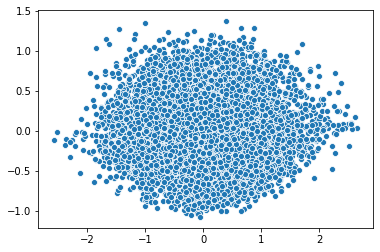

In [0]:
#PCA transformation embeddings (2 dimensions) 

pca = PCA(n_components = 2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x = pca_result[:,0], y = pca_result[:,1])

Check on sum: 1.0


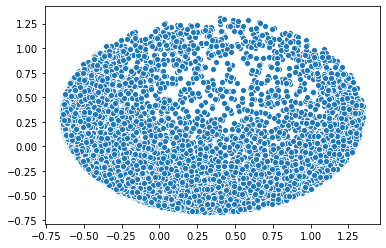

In [0]:
#vector normalization on the axis 1     

book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
#check 
print ('Check on sum:',np.sum(np.square(book_em_weights[0])))

#visualization on PCA space
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [0]:
##TSNE transformation embeddings (2 dimensions)
 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.019s...
[t-SNE] Computed neighbors for 10001 samples in 0.710s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.104689
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.372078
[t-SNE] KL

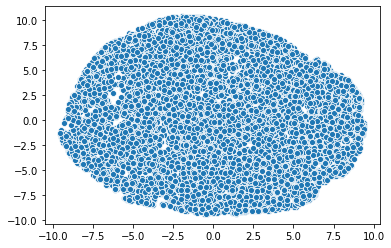

In [0]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Recommendation system

*Content-Base Paradigm:* The system recommend to a user the best books looking for the best predicted ratings for that specific user. Are sown items similar to those appreciated by the user himself in the past.

In [0]:
#creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
print('array book_data: ', book_data[:5])
user = np.array([1 for i in range(len(book_data))])
print ('array user:', user[:5])

array book_data:  [1 2 3 4 5]
array user: [1 1 1 1 1]


In [0]:
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:5]
print('Predicted book ids:', recommended_book_ids)
print('Predicted scores:', predictions[recommended_book_ids])


Predicted book ids: [8945 6919 7946 5206 3627]
Predicted scores: [4.644927  4.619874  4.610486  4.606681  4.5927806]


In [0]:
#first books in dataset
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [0]:
#first five books recommended
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3626,3627,7592279,7592279,9985502,37,1741664489,9.781742e+12,John Flanagan,2011.0,NaN,"The Emperor of Nihon-Ja (Ranger's Apprentice, ...",eng,4.42,29397,33357,1089,226,618,3569,9564,19380,https://images.gr-assets.com/books/1446448563m...,https://images.gr-assets.com/books/1446448563s...
5205,5206,13066,13066,2257006,31,446695688,9.780447e+12,Carl Hiaasen,2000.0,Sick Puppy,Sick Puppy,eng,3.88,18248,19594,1069,193,861,5077,8434,5029,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
6918,6919,55354,55354,893440,22,786887583,9.780787e+12,George Carlin,2001.0,Napalm & Silly Putty,Napalm & Silly Putty,eng,4.12,12798,13437,316,141,465,2561,4724,5546,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7945,7946,39926,39926,836516,43,60512180,9.780061e+12,Naomi Wolf,1990.0,The Beauty Myth: How Images of Beauty Are Used...,The Beauty Myth,eng,3.89,13037,14266,790,234,790,3493,5552,4197,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8944,8945,32529,32529,3214115,40,752848267,9.780753e+12,Lisa Gardner,2001.0,The Next Accident,"The Next Accident (Quincy & Rainie, #3)",en-US,4.16,11261,13328,513,49,231,2323,5612,5113,https://images.gr-assets.com/books/1348816896m...,https://images.gr-assets.com/books/1348816896s...
